In [2]:
import boto3
import json
import numpy as np
import io
import IPython.display
import scipy.io.wavfile as sciwav
from collections import Counter
from s3fs.core import S3FileSystem

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
bucket = 'music-ml-gigioli'

In [4]:
s3 = S3FileSystem()

embeddings, fnames = [], []
for f in s3.walk('s3://music-ml-gigioli/data/nsynth/nsynth-train/embeddings/'):
    if 'acoustic' in f:
        fnames.append(f)
        embeddings.append(np.load(s3.open(f)))

In [5]:
len(embeddings)

4594

In [8]:
embeddings[0].shape

(125, 16)

In [30]:
def dist(mat1, mat2):
    return np.sqrt(((mat1 - mat2)**2).sum())

In [42]:
edge_table = []
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        edge_table.append((i, j, dist(embeddings[i], embeddings[j])))

KeyboardInterrupt: 

### KMeans on averaged embeddings

In [48]:
avg_embeddings = np.mean(embeddings, axis=1)

In [71]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)

In [51]:
clusters = kmeans.fit_predict(avg_embeddings)

In [52]:
instruments = [x.split('/')[-1].split('_')[0] for x in fnames]

In [53]:
results = sorted(list(zip(fnames, clusters)), key=lambda x : x[1])

In [54]:
Counter(list(zip(*results))[1])

Counter({0: 590,
         1: 527,
         2: 283,
         3: 619,
         4: 714,
         5: 374,
         6: 269,
         7: 279,
         8: 120,
         9: 819})

In [55]:
instrument_clusters = sorted(zip(clusters, instruments), key=lambda x : x [1])

In [56]:
instrument_clusters = [[x[1] for x in instrument_clusters if x[0] == i] for i in range(n_clusters)]

In [77]:
data = []
for x in instrument_clusters:
    cts = Counter(x)
    for i in set(instruments):
        cts[i] = cts.get(i, 0)
    data.append([cts[i] for i in sorted(set(instruments))])
    print(list(cts.values()))

[16, 4, 94, 27, 356, 3, 90, 0, 0, 0]
[161, 28, 20, 5, 23, 6, 91, 123, 70, 0]
[5, 14, 58, 72, 129, 5, 0, 0, 0, 0]
[75, 99, 3, 11, 22, 3, 167, 213, 26, 0]
[1, 73, 25, 106, 48, 271, 72, 118, 0, 0]
[11, 1, 71, 53, 191, 2, 45, 0, 0, 0]
[62, 44, 91, 42, 2, 13, 12, 3, 0, 0]
[26, 66, 41, 132, 14, 0, 0, 0, 0, 0]
[24, 2, 24, 1, 64, 1, 4, 0, 0, 0]
[105, 139, 8, 6, 6, 2, 249, 233, 71, 0]


In [66]:
import seaborn as sns

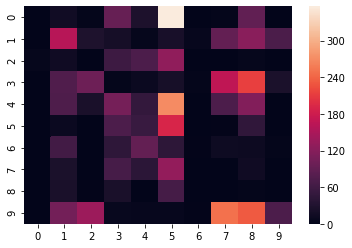

In [80]:
ax = sns.heatmap(data)

### KMeans on flattened embeddings

In [12]:
flattened_embeddings = np.array([x.reshape(-1) for x in embeddings])

In [13]:
kmeans = KMeans(n_clusters=10)

In [14]:
clusters = kmeans.fit_predict(flattened_embeddings)

In [22]:
instruments = [x.split('/')[-1].split('_')[0] for x in fnames]

In [15]:
results = sorted(list(zip(fnames, clusters)), key=lambda x : x[1])

In [16]:
Counter(list(zip(*results))[1])

Counter({0: 383,
         1: 424,
         2: 337,
         3: 791,
         4: 361,
         5: 484,
         6: 758,
         7: 213,
         8: 414,
         9: 429})

In [40]:
instrument_clusters = sorted(zip(clusters, instruments), key=lambda x : x [1])

In [41]:
instrument_clusters = [[x[1] for x in instrument_clusters if x[0] == i] for i in range(10)]

In [45]:
for x in instrument_clusters:
    print(list(Counter(x).values()))

[139, 42, 9, 2, 5, 1, 110, 44, 31]
[11, 2, 65, 70, 202, 2, 72]
[3, 51, 2, 73, 98, 98, 1, 11]
[86, 129, 4, 14, 2, 274, 200, 82]
[2, 19, 70, 87, 174, 9]
[4, 1, 91, 31, 284, 73]
[1, 85, 27, 107, 40, 306, 75, 117]
[17, 64, 10, 121, 1]
[102, 21, 11, 3, 22, 7, 58, 134, 56]
[53, 74, 14, 10, 3, 78, 196, 1]


In [17]:
[x for x in results if x[1] == 2][:5]

[('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/bass_acoustic_000-027-025_embeddings.npy',
  2),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/bass_acoustic_000-035-025_embeddings.npy',
  2),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/bass_acoustic_000-037-050_embeddings.npy',
  2),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_005-071-025_embeddings.npy',
  2),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_005-081-100_embeddings.npy',
  2)]

In [18]:
[x for x in results if x[1] == 0][:10]

[('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_000-075-050_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_001-062-050_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_007-052-127_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_007-065-050_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_007-066-075_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_007-073-075_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_007-076-075_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_010-046-100_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/embeddings/brass_acoustic_010-064-075_embeddings.npy',
  0),
 ('music-ml-gigioli/data/nsynth/nsynth-train/e

In [20]:
obj = boto3.resource('s3').Object(bucket, 'data/nsynth/nsynth-train/audio/brass_acoustic_005-081-100.wav')
sample_rate, X = sciwav.read(io.BytesIO(obj.get()['Body'].read()))
X = X.astype(np.float32)
IPython.display.Audio(X, rate=16000)

In [21]:
obj = boto3.resource('s3').Object(bucket, 'data/nsynth/nsynth-train/audio/brass_acoustic_000-075-050.wav')
sample_rate, X = sciwav.read(io.BytesIO(obj.get()['Body'].read()))
X = X.astype(np.float32)
IPython.display.Audio(X, rate=16000)

In [70]:
[x for x in results if x[1] == 5]

[('data/nsynth/nsynth-train/embeddings/bass_electronic_000-022-100_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_electronic_000-023-025_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_electronic_007-022-050_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_electronic_022-034-075_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_004-076-050_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_005-026-025_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_005-039-127_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_017-070-127_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_017-087-127_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_018-046-075_embeddings.npy',
  5),
 ('data/nsynth/nsynth-train/embeddings/bass_synthetic_018-098-100_embeddings.npy',
  5),
 ('data/nsynth/ns